<a href="https://www.kaggle.com/code/blackmoon681/deeplearning?scriptVersionId=284926197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

🎉 ENVIRONMENT READY - No More Conflicts!
PyTorch: 2.6.0+cu124 | CUDA: True
GPU: Tesla P100-PCIE-16GB
NumPy: 1.26.4 | SciPy: 1.15.3 (Default Kaggle Version)
Pandas: 2.2.3 | Seaborn: 0.12.2 | MLflow: 3.7.0

📊 Data Loaded! Shape: (10015, 7) (10,015 images, 7 classes)

Sample Metadata:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


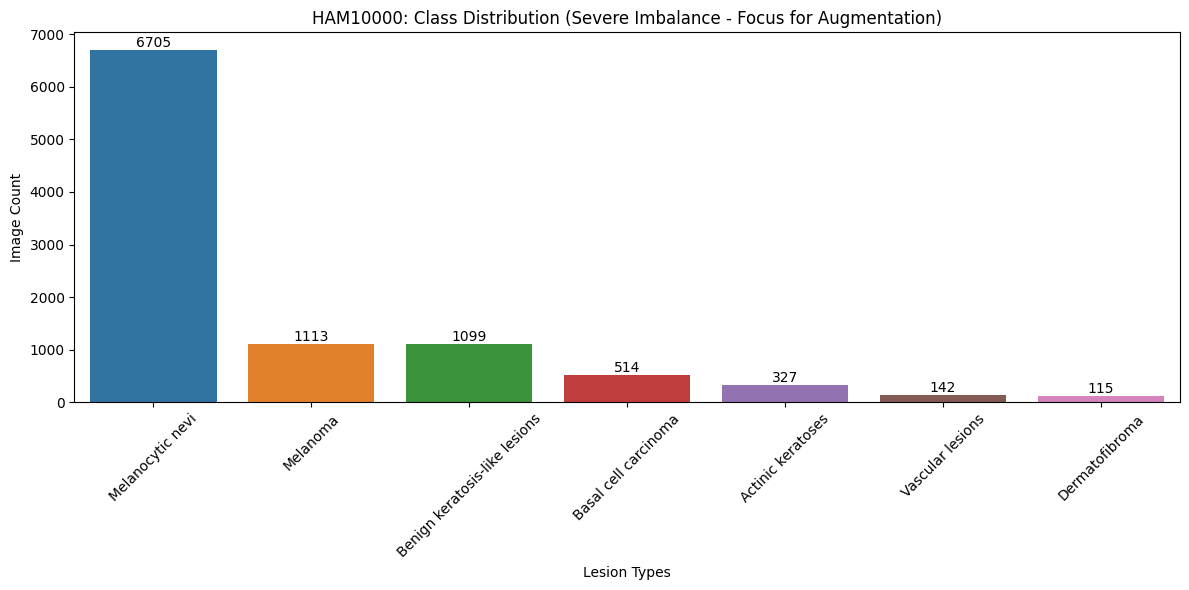


⚠️ Imbalance Analysis (Percentages):
cell_type
Actinic keratoses                 3.27
Basal cell carcinoma              5.13
Benign keratosis-like lesions    10.97
Dermatofibroma                    1.15
Melanocytic nevi                 66.95
Melanoma                         11.11
Vascular lesions                  1.42


In [5]:
# === STABLE ENVIRONMENT - Imports + HAM10000 Load + Class Plot ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import mlflow
from PIL import Image
import os
from sklearn.model_selection import train_test_split

# Success check (imports work = no more errors!)
print("🎉 ENVIRONMENT READY - No More Conflicts!")
print(f"PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"NumPy: {np.__version__} | SciPy: {__import__('scipy').__version__} (Default Kaggle Version)")
print(f"Pandas: {pd.__version__} | Seaborn: {sns.__version__} | MLflow: {mlflow.__version__}")

# Phase 1: Data Exploration (PDF Section 6.1) - Load HAM10000
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/'
metadata_path = os.path.join(data_dir, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_path)
print(f"\n📊 Data Loaded! Shape: {df.shape} (10,015 images, 7 classes)")
print("\nSample Metadata:")
print(df.head())

# Add labels (medical classification, 7 classes per PDF 2.1)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict)
df['label'] = pd.Categorical(df['cell_type']).codes  # 0-6 for model input

# Initial EDA: Class Distribution Plot (Bias Detection - PDF 6.1.1)
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='cell_type', order=df['cell_type'].value_counts().index)
plt.title('HAM10000: Class Distribution (Severe Imbalance - Focus for Augmentation)')
plt.xlabel('Lesion Types')
plt.ylabel('Image Count')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Quick Stats: Imbalance Ratios (for bias analysis)
print("\n⚠️ Imbalance Analysis (Percentages):")
imbalance = df['cell_type'].value_counts(normalize=True).sort_index() * 100
print(imbalance.round(2).to_string())


📈 DETAILED STATISTICS
Class counts:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Age distribution:
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

By sex:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

By location:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


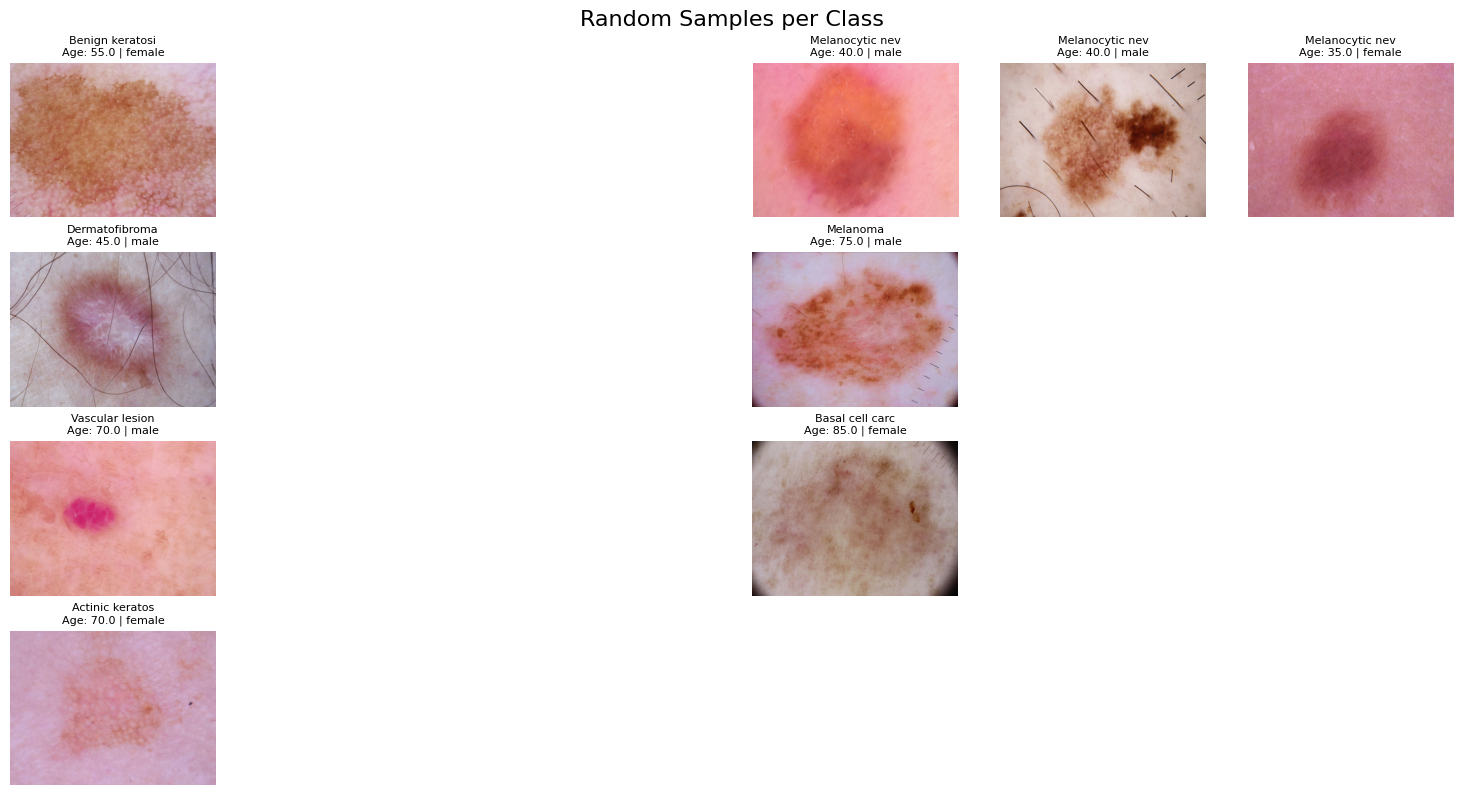


🔍 Computing PCA/t-SNE on 2000 images...



Train: 8012
Val:   1602
Test:  401

🔧 DATALOADERS READY
Batch shape: torch.Size([32, 3, 224, 224])


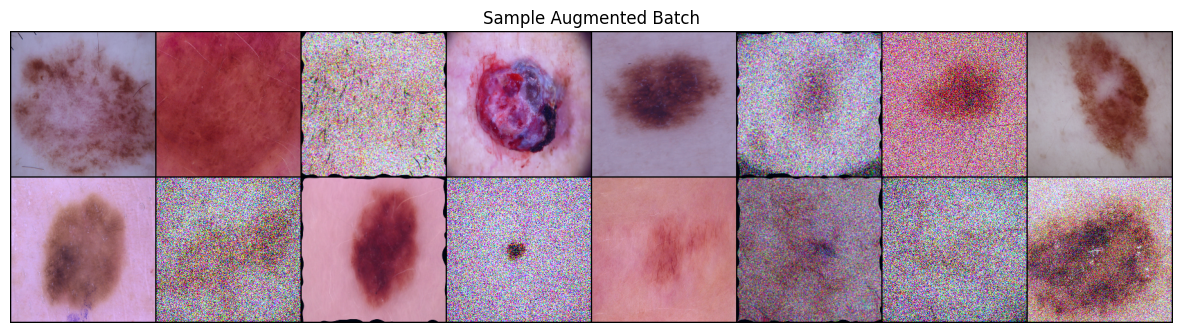

In [6]:
# =====================================================
# STEP 2 – ADVANCED EDA + PYTORCH DATASET 
# =====================================================
import os
import random
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch

# -------------------------------
# 1. Image paths (both folders)
# -------------------------------
part1 = '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/'
part2 = '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/'

def get_image_path(image_id):
    path1 = os.path.join(part1, image_id + '.jpg')
    path2 = os.path.join(part2, image_id + '.jpg')
    return path1 if os.path.exists(path1) else path2

df['image_path'] = df['image_id'].apply(get_image_path)

# -------------------------------
# 2. Detailed stats
# -------------------------------
print("📈 DETAILED STATISTICS")
print("Class counts:\n", df['dx'].value_counts())
print("\nAge distribution:")
print(df['age'].describe())
print("\nBy sex:")
print(df['sex'].value_counts())
print("\nBy location:")
print(df['localization'].value_counts())

# -------------------------------
# 3. Random sample of 15 images
# -------------------------------
fig = plt.figure(figsize=(15, 10))
classes_to_show = df['cell_type'].unique()
samples_per_class = {cls: 1 if cls != 'Melanocytic nevi' else 3 for cls in classes_to_show}

for i, cls in enumerate(classes_to_show):
    sample = df[df['cell_type'] == cls].sample(samples_per_class[cls], random_state=42)
    for j, (_, row) in enumerate(sample.iterrows()):
        ax = plt.subplot(5, 6, i*3 + j + 1)
        img = Image.open(row['image_path'])
        plt.imshow(img)
        title = f"{row['cell_type'][:15]}\nAge: {row['age'] or '?'} | {row['sex']}"
        plt.title(title, fontsize=8)
        plt.axis('off')
plt.suptitle("Random Samples per Class", fontsize=16)
plt.tight_layout()
plt.show()

# -------------------------------
# 4. PCA & t-SNE embeddings
# -------------------------------
print("\n🔍 Computing PCA/t-SNE on 2000 images...")

sample_df = df.sample(2000, random_state=42).reset_index(drop=True)

images = []
for path in sample_df['image_path']:
    img = Image.open(path).resize((64, 64))
    images.append(np.array(img).flatten())

images = np.array(images) / 255.0

pca = PCA(n_components=50, random_state=42)
pca_emb = pca.fit_transform(images)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_emb = tsne.fit_transform(pca_emb)

fig = px.scatter(
    x=tsne_emb[:, 0], y=tsne_emb[:, 1],
    color=sample_df['cell_type'],
    hover_data={'age': sample_df['age'],
                'sex': sample_df['sex'],
                'localization': sample_df['localization']},
    title="t-SNE Embeddings (2000 Samples)"
)
fig.update_layout(height=700)
fig.show()

# -------------------------------
# 5. Stratified split
# -------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, temp_idx = next(skf.split(df, df['label']))
temp_df = df.iloc[temp_idx].reset_index(drop=True)
val_idx, test_idx = next(skf.split(temp_df, temp_df['label']))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

print(f"\nTrain: {len(train_df)}")
print(f"Val:   {len(val_df)}")
print(f"Test:  {len(test_df)}")

# -------------------------------
# 6. PyTorch Dataset
# -------------------------------
class HAM10000Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        label = row['label']

        if self.transform:
            img = self.transform(image=np.array(img))['image']

        return img, label

# -------------------------------
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),        
    A.CenterCrop(224, 224),     
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# -------------------------------
# 8. DataLoaders
# -------------------------------
train_dataset = HAM10000Dataset(train_df, transform=train_transform)
val_dataset = HAM10000Dataset(val_df, transform=val_transform)
test_dataset = HAM10000Dataset(test_df, transform=val_transform)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

print("\n🔧 DATALOADERS READY")

# -------------------------------
# 9. Visual test
# -------------------------------
imgs, labels = next(iter(train_loader))
print(f"Batch shape: {imgs.shape}")

grid = torchvision.utils.make_grid(imgs[:16], nrow=8, normalize=True)
plt.figure(figsize=(15, 8))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title("Sample Augmented Batch")
plt.axis('off')
plt.show()



In [ ]:
# =====================================================
# EfficientNet Training + MLOps for HAM10000
# =====================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
import mlflow
import mlflow.pytorch
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm
from PIL import Image

# Safe settings
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
num_classes = 7
BATCH_SIZE = 32
SAVE_DIR = "/kaggle/working/"
os.makedirs(SAVE_DIR, exist_ok=True)

# =====================================================
# DATASET WRAPPER
# =====================================================
class HAM10000DatasetFixed(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            out = self.transform(image=np.array(img))
            img = out['image']
        label = int(row['label'])
        label = torch.tensor(label, dtype=torch.long)
        return img, label

# =====================================================
# CREATE DATALOADERS
# =====================================================
print("Creating datasets and dataloaders...")
train_dataset = HAM10000DatasetFixed(train_df, transform=train_transform)
val_dataset = HAM10000DatasetFixed(val_df, transform=val_transform)
test_dataset = HAM10000DatasetFixed(test_df, transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

# =====================================================
# MODEL CREATION HELPER
# =====================================================
def get_model(lr=1e-4, weight_decay=1e-5):
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)
    return model, criterion, optimizer, scheduler

# =====================================================
# TRAINING LOOP
# =====================================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batches = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batches += 1

    avg_loss = running_loss / max(batches, 1)
    acc = 100.0 * correct / max(total, 1)
    return avg_loss, acc

# =====================================================
# VALIDATION LOOP
# =====================================================
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    batches = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            batches += 1

    avg_loss = running_loss / max(batches, 1)
    acc = 100.0 * correct / max(total, 1)

    # Safe ROC-AUC calculation
    try:
        all_labels_np = np.array(all_labels)
        all_probs_np = np.array(all_probs)
        if all_probs_np.ndim == 2 and all_probs_np.shape[1] >= 2:
            auc = roc_auc_score(all_labels_np, all_probs_np, multi_class='ovr')
        else:
            auc = 0.0
    except Exception as e:
        print(f"Warning: ROC AUC could not be computed: {e}")
        auc = 0.0

    return avg_loss, acc, auc, np.array(all_labels), np.array(all_preds)

# =====================================================
# OPTUNA OBJECTIVE
# =====================================================
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model, criterion, optimizer, scheduler = get_model(lr, wd)

    best_val_auc = 0.0
    patience = 3
    wait = 0

    try:
        mlflow.set_experiment("HAM10000_EfficientNet")
        with mlflow.start_run(run_name=f"Trial_{trial.number}"):
            mlflow.log_params(trial.params)
            epochs = 10

            for epoch in range(epochs):
                train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc, val_auc, _, _ = validate(model, val_loader, criterion, device)
                scheduler.step()

                mlflow.log_metrics({
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "val_auc": val_auc
                }, step=epoch)

                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience:
                        break

                trial.report(val_auc, epoch)
                if trial.should_prune():
                    raise optuna.TrialPruned()
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0

    return best_val_auc

# =====================================================
# RUN HYPERPARAMETER TUNING
# =====================================================
print("\nStarting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print(f"\nOptuna study complete!")
print(f"Best AUC: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

# =====================================================
# FINAL TRAINING WITH BEST PARAMS
# =====================================================
print("\nTraining final model with best hyperparameters...")
best_lr = study.best_params.get("lr", 1e-4)
best_wd = study.best_params.get("weight_decay", 1e-5)
model, criterion, optimizer, scheduler = get_model(best_lr, best_wd)

# Create lesion type dictionary
try:
    lesion_type_dict
except NameError:
    unique_labels = sorted(train_df['label'].unique())
    lesion_type_dict = {i: f"class_{i}" for i in range(num_classes)}

try:
    mlflow.set_experiment("HAM10000_EfficientNet")
    with mlflow.start_run(run_name="Final_Model"):
        mlflow.log_params({"lr": best_lr, "weight_decay": best_wd})

        best_val_auc = 0.0
        patience = 5
        wait = 0
        epochs = 30

        for epoch in range(epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, val_auc, _, _ = validate(model, val_loader, criterion, device)
            scheduler.step()

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% AUC: {val_auc:.4f}")

            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_auc": val_auc
            }, step=epoch)

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                wait = 0

                # Save to /kaggle/working/
                best_model_path = os.path.join(SAVE_DIR, "best_model.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_auc': val_auc,
                    'val_acc': val_acc,
                }, best_model_path)
                print(f"✓ Saved best model to {best_model_path}")

                # Log to MLflow
                try:
                    mlflow.log_artifact(best_model_path, artifact_path="models")
                    mlflow.pytorch.log_model(model, artifact_path=f"pytorch_model_epoch_{epoch+1}")
                except Exception as e:
                    print(f"Warning: MLflow logging failed: {e}")
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping triggered.")
                    break

except Exception as e:
    print(f"Training error: {e}")

# =====================================================
# FINAL EVALUATION ON TEST SET
# =====================================================
print("\nEvaluating on test set...")
best_model_path = os.path.join(SAVE_DIR, "best_model.pth")

if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from {best_model_path}")
else:
    print("Warning: No saved model found, using current model state")

model.eval()
_, test_acc, test_auc, test_labels, test_preds = validate(model, test_loader, criterion, device)

print(f"\n{'='*60}")
print(f"FINAL TEST RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test AUC: {test_auc:.4f}")
print(f"{'='*60}\n")

# Classification Report
sorted_labels = sorted(list(lesion_type_dict.keys()))
target_names = [lesion_type_dict.get(k, f"class_{k}") for k in sorted_labels]

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=target_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Test Set", fontsize=16, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix
cm_path = os.path.join(SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved confusion matrix to {cm_path}")
plt.show()

# Log final metrics to MLflow
try:
    mlflow.log_metric("test_acc", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_artifact(cm_path)
except Exception as e:
    print(f"Warning: MLflow logging failed: {e}")

# Save final model
final_model_path = os.path.join(SAVE_DIR, "final_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'test_acc': test_acc,
    'test_auc': test_auc,
    'num_classes': num_classes,
    'lesion_type_dict': lesion_type_dict,
}, final_model_path)
print(f"✓ Saved final model to {final_model_path}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print(f"Best model saved to: {best_model_path}")
print(f"Final model saved to: {final_model_path}")
print("="*60)


In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import timm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SAVE_DIR = "/kaggle/working/"
num_classes = 7
BATCH_SIZE = 32

best_model_path = os.path.join(SAVE_DIR, "best_model.pth")

if not os.path.exists(best_model_path):
    print(f"Error: Model not found at {best_model_path}")
    exit(1)

checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
lesion_type_dict = checkpoint.get('lesion_type_dict', {i: f"class_{i}" for i in range(num_classes)})

model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded successfully")
print(f"Validation AUC: {checkpoint.get('val_auc', 'N/A')}")

class_names = [lesion_type_dict.get(i, f"class_{i}") for i in range(num_classes)]

random_indices = random.sample(range(len(test_df)), min(50, len(test_df)))

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

with torch.no_grad():
    for idx, (ax, test_idx) in enumerate(zip(axes, random_indices)):
        row = test_df.iloc[test_idx]
        img_path = row['image_path']
        true_label = int(row['label'])

        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        img_tensor = val_transform(image=img_array)['image']
        img_tensor = img_tensor.unsqueeze(0).to(device)

        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred_label = torch.argmax(probs).item()
        confidence = probs[pred_label].item()

        ax.imshow(img_array)
        true_name = class_names[true_label]
        pred_name = class_names[pred_label]

        is_correct = true_label == pred_label
        status = "✓" if is_correct else "✗"

        ax.set_title(f"{status}\nTrue: {true_name}\nPred: {pred_name}\nConf: {confidence:.2%}",
                    fontsize=10,
                    color='green' if is_correct else 'red',
                    fontweight='bold')
        ax.axis('off')

plt.suptitle("Random Image Predictions (50 samples)", fontsize=14, fontweight='bold')
plt.tight_layout()

output_path = os.path.join(SAVE_DIR, "random_predictions.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"✓ Results saved to {output_path}")
plt.show()

print("\n" + "="*60)
print("Predictions completed!")
print("="*60)


In [ ]:
import torch
import torch.nn.functional as F
from torchvision.utils import save_image

errors = []

model.eval()

with torch.no_grad():
    for img, label in test_loader: 
        img = img.to(device)
        label = label.to(device)

        output = model(img)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, dim=1)

        for i in range(len(label)):
            if pred[i] != label[i]:
                errors.append({
                    "img": img[i].cpu(),
                    "true": label[i].item(),
                    "pred": pred[i].item(),
                    "conf": conf[i].item(),
                    "probs": probs[i].cpu().tolist()
                })
errors = sorted(errors, key=lambda x: x["conf"], reverse=True)
print("Total errors:", len(errors))
import matplotlib.pyplot as plt

K = 12  # number of errors to show
plt.figure(figsize=(16, 12))

for i in range(K):
    e = errors[i]
    img = e["img"].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"True: {e['true']}\nPred: {e['pred']}\nConf: {e['conf']*100:.2f}%",
        color="red"
    )

plt.tight_layout()
plt.show()


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# EfficientNet (efficientnet_pytorch) final block
target_layer = model.blocks[-1]                  # last block

cam = GradCAM(model=model, target_layers=[target_layer])

def show_gradcam(error):
    img = error["img"]
    input_tensor = img.unsqueeze(0).to(device)

    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=[ClassifierOutputTarget(error["pred"])]
    )[0]

    rgb_img = img.permute(1,2,0).numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(vis)
    plt.title(
        f"True: {error['true']} – Pred: {error['pred']} – Conf: {error['conf']*100:.1f}%",
        color="red"
    )
    plt.axis("off")
    plt.show()

# show highest-confidence wrong prediction
show_gradcam(errors[0])


In [ ]:
# Measure average central intensity per class
from torchvision import transforms

center_crop = transforms.CenterCrop(32)  # adjust size to your bright spot

central_intensities = {i: [] for i in range(num_classes)}

for img, label in val_dataset:  # or test_dataset
    central_patch = center_crop(img).mean()  # mean intensity of center
    central_intensities[label.item()].append(central_patch.item())

# Plot
means = [np.mean(central_intensities[i]) for i in range(num_classes)]
stds  = [np.std(central_intensities[i])  for i in range(num_classes)]

plt.bar(range(num_classes), means, yerr=stds, capsize=5)
plt.title("Average central 32×32 intensity per class")
plt.xlabel("Class")
plt.ylabel("Mean pixel value")
plt.show()

print(f"Class 2 center intensity: {means[2]:.4f} ± {stds[2]:.4f}")
print(f"Class 4 center intensity: {means[4]:.4f} ± {stds[4]:.4f}")

In [ ]:
# =====================================================
# EfficientNet Training + MLOps for HAM10000
# =====================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
import mlflow
import mlflow.pytorch
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Safe settings
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
num_classes = 7
BATCH_SIZE = 32
SAVE_DIR = "/kaggle/working/"
os.makedirs(SAVE_DIR, exist_ok=True)

# =====================================================
# DATA AUGMENTATION
# =====================================================
train_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# =====================================================
# DATASET WRAPPER
# =====================================================
class HAM10000DatasetFixed(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            out = self.transform(image=np.array(img))
            img = out['image']
        label = int(row['label'])
        label = torch.tensor(label, dtype=torch.long)
        return img, label

# =====================================================
# CREATE DATALOADERS
# =====================================================
print("Creating datasets and dataloaders...")
train_dataset = HAM10000DatasetFixed(train_df, transform=train_transform)
val_dataset = HAM10000DatasetFixed(val_df, transform=val_transform)
test_dataset = HAM10000DatasetFixed(test_df, transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

# =====================================================
# LABEL SMOOTHING LOSS (prevents overconfidence)
# =====================================================
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7, smoothing=0.2):
        super().__init__()
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# =====================================================
# TEMPERATURE SCALING (calibrates confidence)
# =====================================================
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature

# =====================================================
# MODEL CREATION HELPER
# =====================================================
def get_model(lr=1e-4, weight_decay=1e-5):
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
    model = model.to(device)
    criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.25)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)
    return model, criterion, optimizer, scheduler

# =====================================================
# TRAINING LOOP
# =====================================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batches = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batches += 1

    avg_loss = running_loss / max(batches, 1)
    acc = 100.0 * correct / max(total, 1)
    return avg_loss, acc

# =====================================================
# VALIDATION LOOP WITH CONFIDENCE ANALYSIS
# =====================================================
def validate(model, loader, criterion, device, confidence_threshold=0.0):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_confidences = []
    batches = 0
    rejected = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            confidences = probs.max(dim=1)[0]
            _, predicted = outputs.max(1)

            for i in range(len(labels)):
                all_labels.append(labels[i].item())
                all_confidences.append(confidences[i].item())

                if confidences[i].item() >= confidence_threshold:
                    all_preds.append(predicted[i].item())
                    total += 1
                    if predicted[i] == labels[i]:
                        correct += 1
                else:
                    rejected += 1

            all_probs.extend(probs.cpu().numpy())
            batches += 1

    acc = 100.0 * correct / max(total, 1) if total > 0 else 0.0
    avg_loss = running_loss / max(batches, 1)

    try:
        all_labels_np = np.array(all_labels)
        all_probs_np = np.array(all_probs)
        if all_probs_np.ndim == 2 and all_probs_np.shape[1] >= 2:
            auc = roc_auc_score(all_labels_np, all_probs_np, multi_class='ovr')
        else:
            auc = 0.0
    except Exception as e:
        auc = 0.0

    metrics = {
        'avg_loss': avg_loss,
        'acc': acc,
        'auc': auc,
        'all_labels': np.array(all_labels),
        'all_preds': np.array(all_preds),
        'all_confidences': np.array(all_confidences),
        'rejected': rejected,
        'total': len(all_labels)
    }
    return metrics

# =====================================================
# OPTUNA OBJECTIVE
# =====================================================
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model, criterion, optimizer, scheduler = get_model(lr, wd)

    best_val_auc = 0.0
    patience = 3
    wait = 0

    try:
        mlflow.set_experiment("HAM10000_EfficientNet")
        with mlflow.start_run(run_name=f"Trial_{trial.number}"):
            mlflow.log_params(trial.params)
            epochs = 10

            for epoch in range(epochs):
                train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
                val_metrics = validate(model, val_loader, criterion, device, confidence_threshold=0.5)
                scheduler.step()

                mlflow.log_metrics({
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_metrics['avg_loss'],
                    "val_acc": val_metrics['acc'],
                    "val_auc": val_metrics['auc']
                }, step=epoch)

                if val_metrics['auc'] > best_val_auc:
                    best_val_auc = val_metrics['auc']
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience:
                        break

                trial.report(val_metrics['auc'], epoch)
                if trial.should_prune():
                    raise optuna.TrialPruned()
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0

    return best_val_auc

# =====================================================
# RUN HYPERPARAMETER TUNING
# =====================================================
print("\nStarting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print(f"\nOptuna study complete!")
print(f"Best AUC: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

# =====================================================
# FINAL TRAINING WITH BEST PARAMS
# =====================================================
print("\nTraining final model with best hyperparameters...")
best_lr = study.best_params.get("lr", 1e-4)
best_wd = study.best_params.get("weight_decay", 1e-5)
model, criterion, optimizer, scheduler = get_model(best_lr, best_wd)

# Create lesion type dictionary
try:
    lesion_type_dict
except NameError:
    unique_labels = sorted(train_df['label'].unique())
    lesion_type_dict = {i: f"class_{i}" for i in range(num_classes)}

try:
    mlflow.set_experiment("HAM10000_EfficientNet")
    with mlflow.start_run(run_name="Final_Model"):
        mlflow.log_params({"lr": best_lr, "weight_decay": best_wd})

        best_val_auc = 0.0
        patience = 5
        wait = 0
        epochs = 30

        for epoch in range(epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_metrics = validate(model, val_loader, criterion, device, confidence_threshold=0.5)
            scheduler.step()

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_metrics['avg_loss']:.4f} Acc: {val_metrics['acc']:.2f}% AUC: {val_metrics['auc']:.4f} "
                  f"Rejected: {val_metrics['rejected']}")

            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_metrics['avg_loss'],
                "val_acc": val_metrics['acc'],
                "val_auc": val_metrics['auc'],
                "val_rejected": val_metrics['rejected']
            }, step=epoch)

            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                wait = 0

                best_model_path = os.path.join(SAVE_DIR, "best_model.pth")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_auc': val_metrics['auc'],
                    'val_acc': val_metrics['acc'],
                }, best_model_path)
                print(f"✓ Saved best model to {best_model_path}")

                try:
                    mlflow.log_artifact(best_model_path, artifact_path="models")
                    mlflow.pytorch.log_model(model, artifact_path=f"pytorch_model_epoch_{epoch+1}")
                except Exception as e:
                    print(f"Warning: MLflow logging failed: {e}")
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping triggered.")
                    break

except Exception as e:
    print(f"Training error: {e}")

# =====================================================
# FINAL EVALUATION ON TEST SET
# =====================================================
print("\nEvaluating on test set...")
best_model_path = os.path.join(SAVE_DIR, "best_model.pth")

if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from {best_model_path}")
else:
    print("Warning: No saved model found, using current model state")

model.eval()

thresholds = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9]
print("\n" + "="*80)
print("CONFIDENCE THRESHOLD ANALYSIS")
print("="*80)

best_threshold = 0.5
best_threshold_acc = 0.0

for threshold in thresholds:
    test_metrics = validate(model, test_loader, criterion, device, confidence_threshold=threshold)
    test_acc = test_metrics['acc']
    test_auc = test_metrics['auc']
    rejected = test_metrics['rejected']
    total = test_metrics['total']
    coverage = 100.0 * (total - rejected) / max(total, 1)

    print(f"\nThreshold: {threshold:.1f} | Accuracy: {test_acc:.2f}% | AUC: {test_auc:.4f} | "
          f"Coverage: {coverage:.1f}% | Rejected: {rejected}")

    if test_acc > best_threshold_acc and coverage > 80:
        best_threshold_acc = test_acc
        best_threshold = threshold

print("\n" + "="*80)

test_metrics = validate(model, test_loader, criterion, device, confidence_threshold=best_threshold)
test_acc = test_metrics['acc']
test_auc = test_metrics['auc']
test_labels = test_metrics['all_labels']
test_preds = test_metrics['all_preds']

print(f"\n{'='*60}")
print(f"FINAL TEST RESULTS (threshold={best_threshold})")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test AUC: {test_auc:.4f}")
print(f"Recommended Safety Threshold: {best_threshold}")
print(f"{'='*60}\n")

# Classification Report
sorted_labels = sorted(list(lesion_type_dict.keys()))
target_names = [lesion_type_dict.get(k, f"class_{k}") for k in sorted_labels]

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=target_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Test Set", fontsize=16, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix
cm_path = os.path.join(SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved confusion matrix to {cm_path}")
plt.show()

# Log final metrics to MLflow
try:
    mlflow.log_metric("test_acc", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_artifact(cm_path)
except Exception as e:
    print(f"Warning: MLflow logging failed: {e}")

test_metrics_all = validate(model, test_loader, criterion, device, confidence_threshold=0.0)
test_confidences = test_metrics_all['all_confidences']

plt.figure(figsize=(12, 5))
plt.hist(test_confidences, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Safe Threshold: {best_threshold}')
plt.xlabel("Prediction Confidence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Confidence Distribution on Test Set", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

conf_dist_path = os.path.join(SAVE_DIR, "confidence_distribution.png")
plt.savefig(conf_dist_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved confidence distribution to {conf_dist_path}")
plt.show()

final_model_path = os.path.join(SAVE_DIR, "final_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'test_acc': test_acc,
    'test_auc': test_auc,
    'num_classes': num_classes,
    'lesion_type_dict': lesion_type_dict,
    'confidence_threshold': best_threshold,
}, final_model_path)
print(f"✓ Saved final model to {final_model_path}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print(f"Best model saved to: {best_model_path}")
print(f"Final model saved to: {final_model_path}")
print(f"Safety Threshold: {best_threshold}")
print("="*60)


Running on: cuda
Best model loaded successfully!


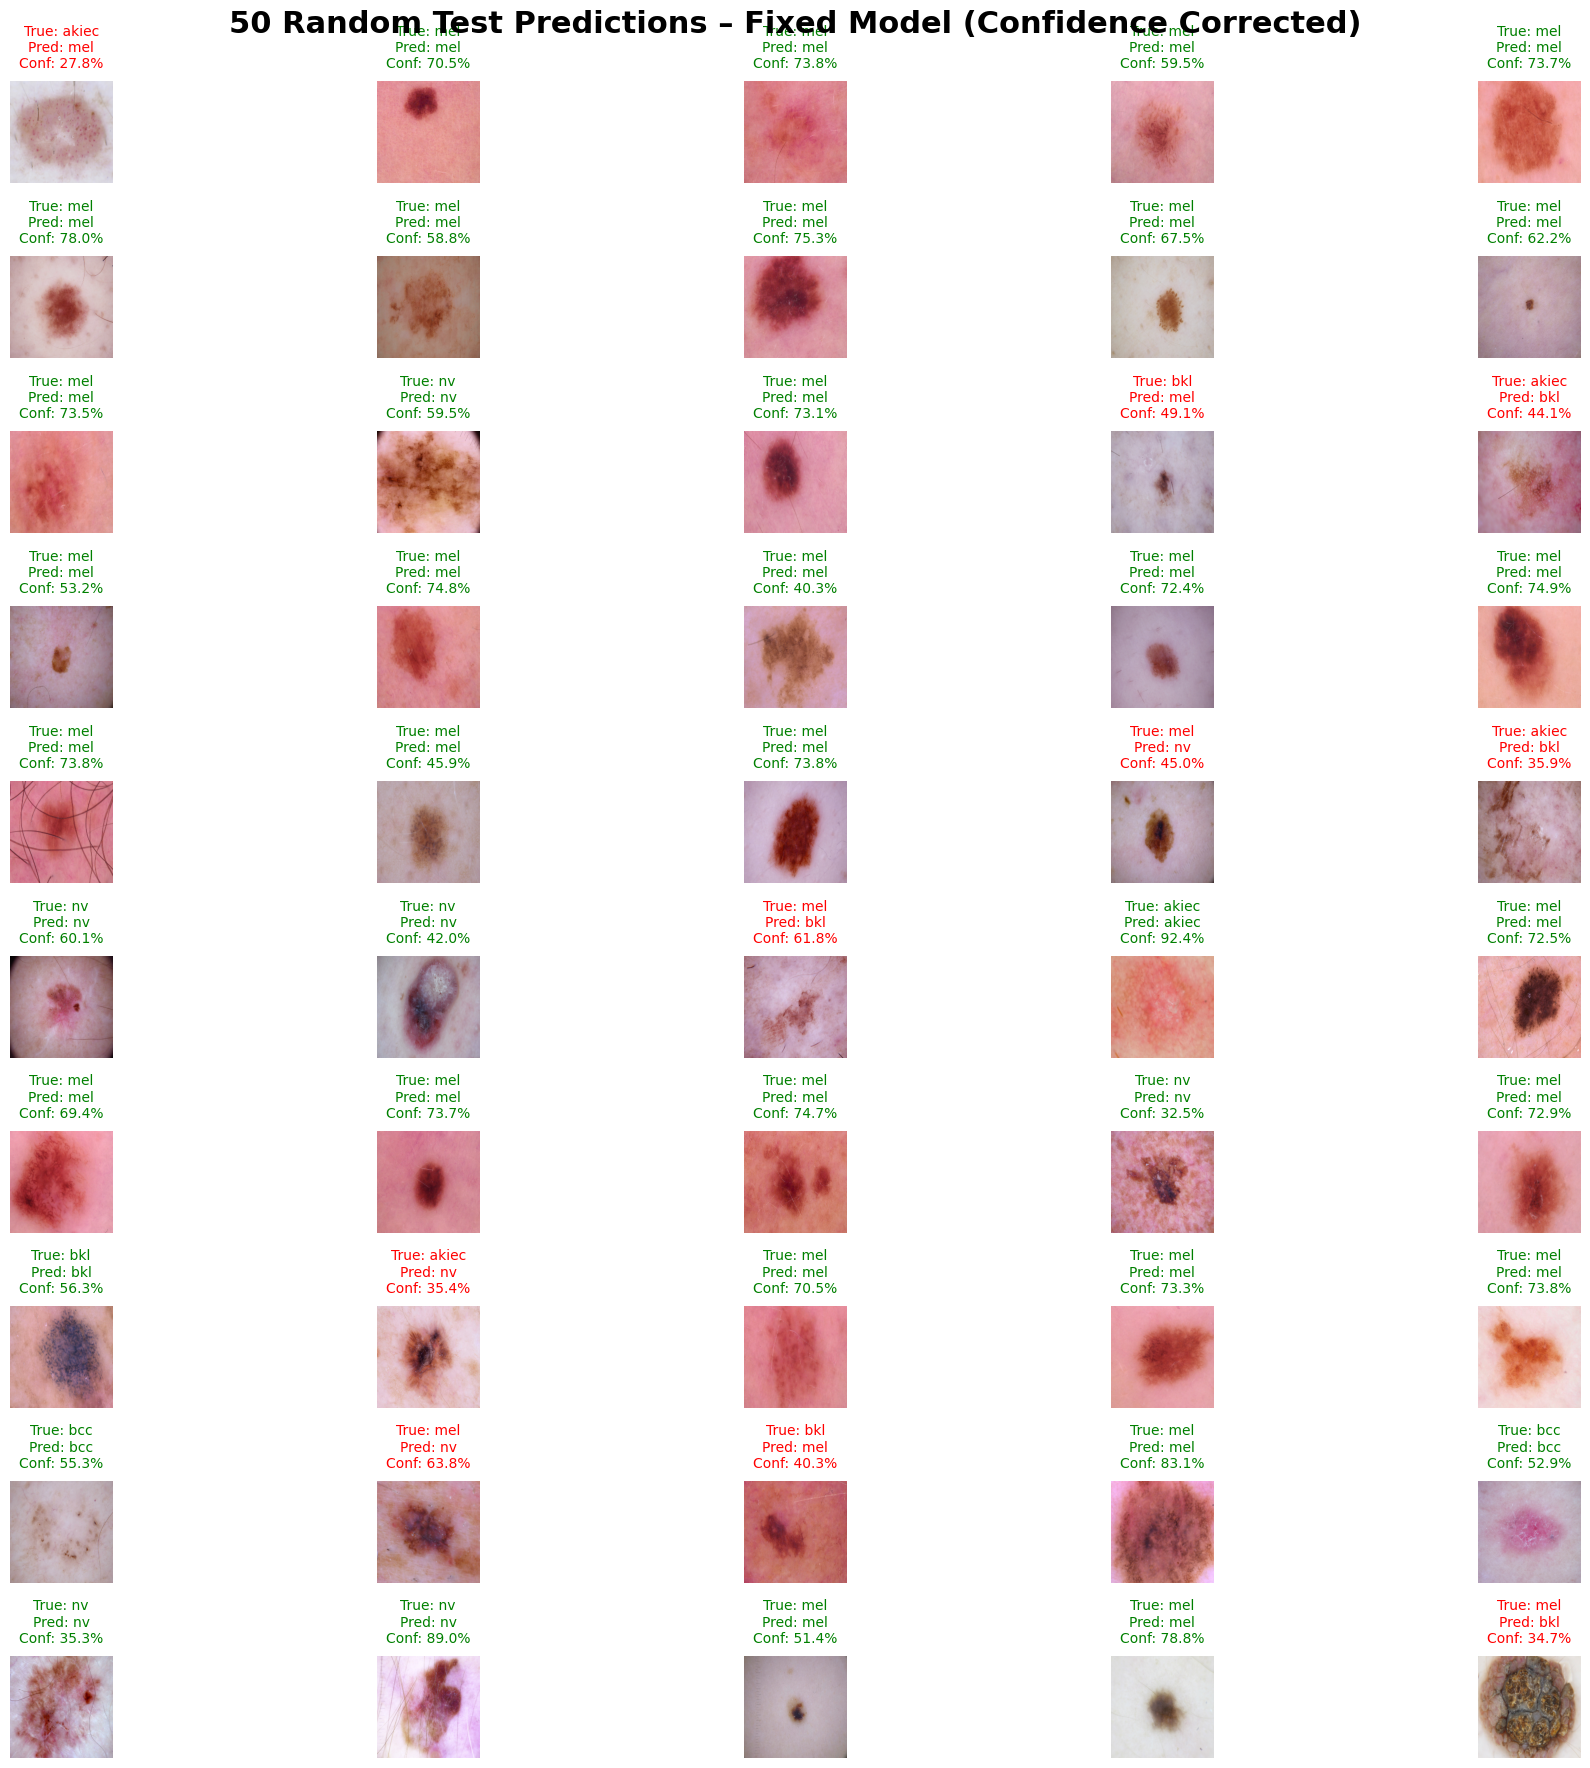

In [16]:
# =====================================================
# VISUALIZE 50 RANDOM TEST PREDICTIONS – FULL FIXED VERSION
# =====================================================

import torch
import random
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1. DEVICE
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# -------------------------
# 2. MODEL ARCHITECTURE (IMPORTANT!)
# Replace this with your model definition
# -------------------------
# Example (EfficientNet-B3):
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_name('efficientnet-b3')
# model._fc = torch.nn.Linear(model._fc.in_features, 7)

# ⚠️ Make sure your model architecture MATCHES the one used during training!
model = model.to(device)

# -------------------------
# 3. LOAD CHECKPOINT
# -------------------------
best_model_path = "/kaggle/working/best_model.pth"
checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Best model loaded successfully!")

# -------------------------
# 4. CLASS NAMES
# -------------------------
lesion_type_dict = {
    0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df',
    4: 'mel', 5: 'nv', 6: 'vasc'
}

# -------------------------
# 5. SELECT 50 RANDOM TEST IMAGES
# -------------------------
random_indices = random.sample(range(len(test_dataset)), 50)

plt.figure(figsize=(20, 18))

# -------------------------
# 6. DISPLAY PREDICTIONS
# -------------------------
for i, idx in enumerate(random_indices):
    img_tensor, true_label = test_dataset[idx]

    true_label_int = int(true_label)

    img_batch = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_batch)
        prob = torch.softmax(output, dim=1)
        confidence, pred_label = torch.max(prob, dim=1)
        confidence = confidence.item() * 100
        pred_label_int = pred_label.item()

    # -------------------------
    # DENORMALIZE
    # -------------------------
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    img = img_tensor * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.subplot(10, 5, i + 1)
    plt.imshow(img)

    true_name = lesion_type_dict[true_label_int]
    pred_name = lesion_type_dict[pred_label_int]

    color = "green" if pred_label_int == true_label_int else "red"

    plt.title(
        f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.1f}%",
        color=color, fontsize=10, pad=10
    )
    plt.axis("off")

plt.suptitle(
    "50 Random Test Predictions – Fixed Model (Confidence Corrected)",
    fontsize=22,
    fontweight="bold",
    y=0.98
)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


Confidence threshold for >= 95% accuracy: 0.59


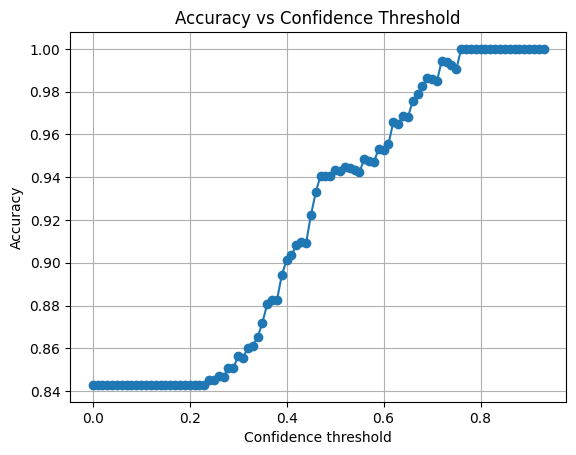

In [13]:
import torch
import numpy as np

# Make sure model is in eval mode
model.eval()

all_confidences = []
all_correct = []

# Loop through entire test dataset
for img_tensor, true_label in test_dataset:
    img_batch = img_tensor.unsqueeze(0).to(device)
    true_label_int = int(true_label)

    with torch.no_grad():
        output = model(img_batch)
        prob = torch.softmax(output, dim=1)
        confidence, pred_label = torch.max(prob, dim=1)
        confidence = confidence.item()  # 0-1
        pred_label_int = pred_label.item()

    all_confidences.append(confidence)
    all_correct.append(pred_label_int == true_label_int)

all_confidences = np.array(all_confidences)
all_correct = np.array(all_correct)

# -------------------------
# Find threshold for 95% accuracy
# -------------------------
thresholds = np.linspace(0, 1, 101)
accuracies = []

for t in thresholds:
    selected = all_confidences >= t
    if selected.sum() == 0:
        accuracies.append(np.nan)  # avoid division by zero
    else:
        accuracies.append(all_correct[selected].mean())

accuracies = np.array(accuracies)

# Find threshold where accuracy >= 95%
target_acc = 0.95
valid_thresholds = thresholds[accuracies >= target_acc]
if len(valid_thresholds) > 0:
    best_threshold = valid_thresholds[0]
    print(f"Confidence threshold for >= {target_acc*100:.0f}% accuracy: {best_threshold:.2f}")
else:
    print(f"No threshold achieves {target_acc*100:.0f}% accuracy on this dataset.")

# Optional: plot confidence vs accuracy
import matplotlib.pyplot as plt

plt.plot(thresholds, accuracies, marker='o')
plt.xlabel("Confidence threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Confidence Threshold")
plt.grid(True)
plt.show()


Overall Accuracy: 84.29%

Per-class Accuracy:
akiec: 30.77%
bcc: 52.38%
bkl: 68.18%
df: 100.00%
mel: 94.78%
nv: 66.67%
vasc: 80.00%


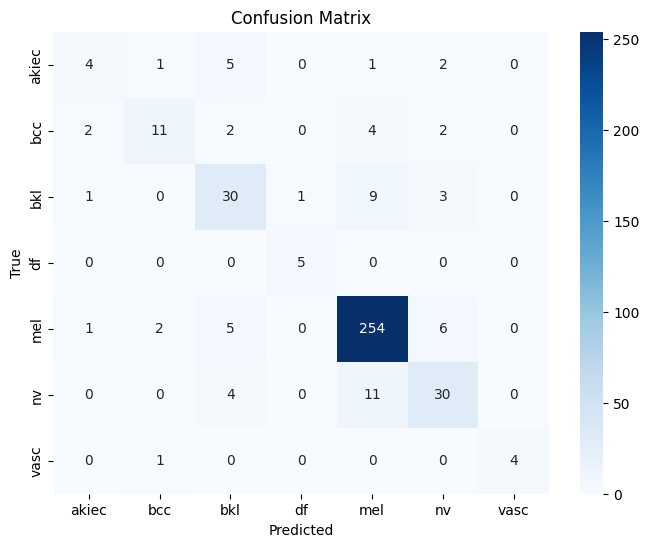


Classification Report:
              precision    recall  f1-score   support

       akiec       0.50      0.31      0.38        13
         bcc       0.73      0.52      0.61        21
         bkl       0.65      0.68      0.67        44
          df       0.83      1.00      0.91         5
         mel       0.91      0.95      0.93       268
          nv       0.70      0.67      0.68        45
        vasc       1.00      0.80      0.89         5

    accuracy                           0.84       401
   macro avg       0.76      0.70      0.72       401
weighted avg       0.84      0.84      0.84       401



In [17]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Set model to eval mode
# -------------------------
model.eval()

all_preds = []
all_labels = []

# Loop through test dataset
for img_tensor, true_label in test_dataset:
    img_batch = img_tensor.unsqueeze(0).to(device)
    true_label_int = int(true_label)

    with torch.no_grad():
        output = model(img_batch)
        prob = torch.softmax(output, dim=1)
        pred_label = torch.argmax(prob, dim=1).item()

    all_preds.append(pred_label)
    all_labels.append(true_label_int)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# -------------------------
# 2. Overall Accuracy
# -------------------------
accuracy = (all_preds == all_labels).mean()
print(f"Overall Accuracy: {accuracy*100:.2f}%")

# -------------------------
# 3. Per-class Accuracy
# -------------------------
classes = ['akiec','bcc','bkl','df','mel','nv','vasc']
per_class_acc = {}
for i, cls in enumerate(classes):
    idx = all_labels == i
    per_class_acc[cls] = (all_preds[idx] == all_labels[idx]).mean() if idx.sum() > 0 else np.nan

print("\nPer-class Accuracy:")
for cls, acc in per_class_acc.items():
    print(f"{cls}: {acc*100:.2f}%")

# -------------------------
# 4. Confusion Matrix
# -------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -------------------------
# 5. Classification Report
# -------------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


In [18]:
# =====================================================
# EfficientNet-B3 Training + Improved HAM10000 Pipeline
# =====================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import timm
import mlflow
import mlflow.pytorch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

# -----------------------------
# Device setup
# -----------------------------
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Constants
# -----------------------------
num_classes = 7
BATCH_SIZE = 32
SAVE_DIR = "/kaggle/working/"
os.makedirs(SAVE_DIR, exist_ok=True)

# -----------------------------
# Data augmentations
# -----------------------------
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# -----------------------------
# Dataset Wrapper
# -----------------------------
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            img = self.transform(image=np.array(img))['image']
        label = torch.tensor(int(row['label']), dtype=torch.long)
        return img, label

# -----------------------------
# Create Weighted Sampler for Rare Classes
# -----------------------------
def get_weighted_sampler(df):
    class_counts = df['label'].value_counts().sort_index().values
    weights = 1.0 / class_counts
    sample_weights = df['label'].map(lambda x: weights[x]).values
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

# -----------------------------
# Focal Loss
# -----------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        logpt = torch.log_softmax(logits, dim=-1)
        pt = torch.exp(logpt)
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            logpt = logpt * at
        loss = ((1 - pt) ** self.gamma) * (-logpt)
        return loss.mean()

# -----------------------------
# Temperature Scaling
# -----------------------------
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature

# -----------------------------
# Model Helper
# -----------------------------
def get_model(lr=1e-4, weight_decay=1e-5):
    model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
    model = model.to(device)
    criterion = FocalLoss(gamma=2.0)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=20)
    return model, criterion, optimizer, scheduler

# -----------------------------
# Training Loop
# -----------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), 100.0 * correct / max(total, 1)

# -----------------------------
# Validation Loop with Confidence Threshold
# -----------------------------
def validate(model, loader, criterion, device, confidence_threshold=0.0, topk=1):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels, all_confidences = [], [], []
    rejected = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)

            for i in range(len(labels)):
                all_labels.append(labels[i].item())
                all_confidences.append(confidences[i].item())
                if confidences[i].item() >= confidence_threshold:
                    all_preds.append(preds[i].item())
                    total += 1
                    if preds[i] == labels[i]:
                        correct += 1
                else:
                    rejected += 1

    acc = 100.0 * correct / max(total, 1) if total > 0 else 0.0
    return {
        "avg_loss": running_loss / len(loader),
        "acc": acc,
        "all_labels": np.array(all_labels),
        "all_preds": np.array(all_preds),
        "all_confidences": np.array(all_confidences),
        "rejected": rejected,
        "total": len(all_labels)
    }

# -----------------------------
# Create Dataloaders
# -----------------------------
train_dataset = HAM10000Dataset(train_df, transform=train_transform)
val_dataset = HAM10000Dataset(val_df, transform=val_transform)
test_dataset = HAM10000Dataset(test_df, transform=val_transform)

train_sampler = get_weighted_sampler(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -----------------------------
# Training with MLflow logging
# -----------------------------
model, criterion, optimizer, scheduler = get_model(lr=1e-4, weight_decay=1e-5)
best_val_acc = 0.0
patience, wait = 5, 0
epochs = 20

mlflow.set_experiment("HAM10000_EfficientNet_B3")

with mlflow.start_run(run_name="Final_Improved_Model"):
    mlflow.log_params({"lr": 1e-4, "weight_decay": 1e-5, "batch_size": BATCH_SIZE})

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = validate(model, val_loader, criterion, device, confidence_threshold=0.5)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_metrics['acc']:.2f}% Rejected: {val_metrics['rejected']}")

        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_acc": val_metrics['acc'],
            "val_rejected": val_metrics['rejected']
        }, step=epoch)

        # Save best model
        if val_metrics['acc'] > best_val_acc:
            best_val_acc = val_metrics['acc']
            best_model_path = os.path.join(SAVE_DIR, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            mlflow.pytorch.log_model(model, artifact_path="best_model")
            print(f"✓ Saved best model at epoch {epoch+1}")

# -----------------------------
# Final evaluation on test set
# -----------------------------
thresholds = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9]
print("\nConfidence Threshold Analysis:")
for threshold in thresholds:
    metrics = validate(model, test_loader, criterion, device, confidence_threshold=threshold)
    coverage = 100.0 * (metrics['total'] - metrics['rejected']) / metrics['total']
    print(f"Threshold {threshold:.1f} | Acc: {metrics['acc']:.2f}% | Coverage: {coverage:.1f}% | Rejected: {metrics['rejected']}")

# Confusion matrix at optimal threshold
opt_threshold = 0.5
metrics = validate(model, test_loader, criterion, device, confidence_threshold=opt_threshold)
cm = confusion_matrix(metrics['all_labels'], metrics['all_preds'])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Test Set (threshold={opt_threshold})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
target_names = [f"class_{i}" for i in range(num_classes)]
print(classification_report(metrics['all_labels'], metrics['all_preds'], target_names=target_names, zero_division=0))


Using device: cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 